# Assignment 2 - Feature extraction and classification

In this assignment, you are expected to

(1) extract global features from a publicly available dataset with one of the pre-trained neural networks available in pytorch, 

and 

(2) classify the dataset using the traditional k-Neural Neighbours classifier.

You are also asked to implement k-fold cross-validation to evaluate your model.

------------------------

In [3]:
# Load needed packages
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

When working with Pytorch, dataloader() is a must to know function.

Read more about this function and the parameters it accepts in https://blog.paperspace.com/dataloaders-abstractions-pytorch/ ;

DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

The variable transform encapsulates the needed transformations of our data

Read more about transforms in https://blog.paperspace.com/dataloaders-abstractions-pytorch/

In [4]:
transform = transforms.Compose([
    # resize
    transforms.Resize(32),
    # center-crop
    transforms.CenterCrop(32),
    # to-tensor
    transforms.ToTensor(),
    # normalize
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

--------------------------------

# INPUT DATASET

--------------------------------

Load your dataset

In [5]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Example solution for the CIFAR dataset - Please, select the one you worked with in Assignment 1
# dataset = 'CIFAR10'
classes = ('plane', 'car', 'bird', 
           'cat','deer', 'dog', 'frog', 
           'horse', 'ship', 'truck')

train = CIFAR10(root='./', train=True, download=True, transform=transform)
test = CIFAR10(root='./', train=False, download=True, transform=transform)

train_dataloader = DataLoader(train, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test, batch_size=4, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Exercise: Dataset preparation

### Train - Test Split

Write a function **train_test_split(dataset, ratio)** which takes a dataset as an input and returns two datasets one for training and another for testing.


In [16]:
# def train_test_split(dataset):
#     test = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=transform)
#
#     return dataset, test

--------------------------------

# FEATURE EXTRACTION

Extract descriptros from the images in your train and test dataset. The dataset split should remain the same for all the experiments if you want to be fair when comparing performance.

--------------------------------

## Exercise: Feature 1 - RGB descriptros

Following the code you implement in Assignment 1, extract R, G, and B descriptros from the images and concatenate them to create a 1D feature vector of 24 values.

In [6]:
# your code here
def get_descriptors(data):
    nSamples = data.shape[0]
    descriptor = np.zeros((nSamples, 24))

    for i in range(nSamples):
        img = np.transpose(data[i], (1, 2, 0))

        r = img[:, :, 0].flatten()
        g = img[:, :, 1].flatten()
        b = img[:, :, 2].flatten()

        r_hist, _ = np.histogram(r, bins=8)
        g_hist, _ = np.histogram(g, bins=8)
        b_hist, _ = np.histogram(b, bins=8)

        descriptor[i, :] = np.concatenate((r_hist, g_hist, b_hist))

    return descriptor


train_descriptors, test_descriptors = get_descriptors(train.data), get_descriptors(test.data)

In [7]:
train_descriptors.shape, test_descriptors.shape

((50000, 24), (10000, 24))

## Exercise: Feature 2 - Extract descriptors using pre-traind networks

Load pretrained a network to extract global features from the images. 
We will use the values of the last fully connected layer of the deep network as a descriptor, i.e. we will remove the last fully-connected layer. Therefore, after feed-fowarding the input through the network, we save the output as the descriptor of the image.

You can use different networks for this purpose.

Reading material to start with;

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#sphx-glr-beginner-transfer-learning-tutorial-py

https://medium.com/analytics-vidhya/cnn-transfer-learning-with-vgg-16-and-resnet-50-feature-extraction-for-image-retrieval-with-keras-53320c580853

In [8]:
from torchvision import models
import torch.nn as nn

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model = nn.Sequential(*list(model.children())[:-2])

def get_cnn_descriptors(data, loader):
    cnn_descriptors = np.zeros((data.shape[0], 513))

    with torch.no_grad():
        model.eval()

        for j, (inputs, labels) in enumerate(loader):
            outputs = np.array(model(inputs))[:, :, 0, 0]
            cnn_descriptors[j:j+4, :512] = outputs
            cnn_descriptors[j:j+4, 512] = labels
    return cnn_descriptors

cnn_train_descriptors, cnn_test_descriptors = get_cnn_descriptors(train.data, train_dataloader), get_cnn_descriptors(test.data, test_dataloader)


# name of the model you wish to use - it should be selected from this list
# [resnet, alexnet, vgg, squeezenet, densenet, inception]

/Users/kjwdamme/.conda/envs/assignmentsDS/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kjwdamme/.conda/envs/assignmentsDS/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [57]:
# cnn_train_descriptors.shape, cnn_test_descriptors.shape

------------------------

# PERFORMANCE EVALUATION

------------------------

## Exercise: Error function

Implement a function to evaluate the accuracy of your prediction. 
We will rely on the evaluation metric accuracy.

You are suggested to also use f-score, recall and precision. Have a look at https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html 

In [9]:
def accuracy_metric(actual, predicted):
    # print(type(actual), type(predicted))
    corr = np.sum(actual == predicted)
    
    return corr/len(actual)

--------------------------------

# TRAIN AND TEST YOUR MODEL

--------------------------------

## Exercise: k Nearest Neighbour model

Apply the classifier with different values of k (number of nearest neighbours) to the two sets of previously extracted descriptors (RGB and CNN features) and evaluate the performance of your models (accuracy).

You can have a look at the documentation to understand the parameters that define the learning of the model,
https://scikit-learn.org/stable/modules/neighbors.html


In [10]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

In [11]:
# Use your k-NN - play with the value of the parameters to see how the model performs
kvalue_list = [2, 4, 6, 10, 15, 20, 100]

rgb_results = {}
cnn_results = {}

for k in kvalue_list:
    for model_type in ["cnn", "rgb"]:
        if model_type == "cnn":
            model_cnn = KNeighborsClassifier(k)
            model_cnn.fit(cnn_train_descriptors[:, :512], cnn_train_descriptors[:, 512])

            cnn_output = model_cnn.predict(cnn_test_descriptors[:, :512])
            actual = cnn_test_descriptors[:, 512]
            cnn_results[k] = accuracy_metric(actual, cnn_output)
        else:
            model_rgb = KNeighborsClassifier(k)
            model_rgb.fit(train_descriptors, train.targets)

            rgb_output = model_rgb.predict(test_descriptors)
            actual = np.array(test.targets)
            rgb_results[k] = accuracy_metric(actual, rgb_output)

rgb_results, cnn_results

({2: 0.141,
  4: 0.1535,
  6: 0.161,
  10: 0.1692,
  15: 0.1729,
  20: 0.1802,
  100: 0.1958},
 {2: 0.8581,
  4: 0.8676,
  6: 0.8737,
  10: 0.8804,
  15: 0.8825,
  20: 0.8826,
  100: 0.8825})

## Exercise: Visualize results 

Steps to follow:

1) Apply PCA and select the 2 first principal components to represent each sample.

2) Plot the samples with dots. Use a colour per class. 

3) Plot the samples again but with empty filled circles. Use the color of the class predicted per sample (misclassifications will make the colours not coincide).

You can do this for (1) training and (2) test set. In (1) you can see how well the method fits the training data and (2) will give you an idea of the misclassifications.

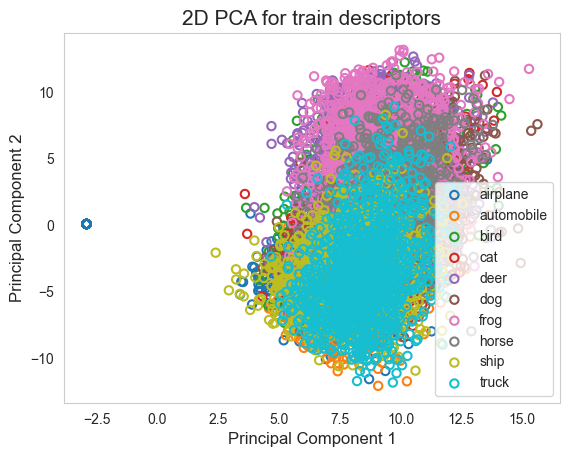

In [159]:
# your code here

from sklearn.decomposition import PCA
import pandas as pd
from matplotlib.markers import MarkerStyle

pca = PCA(n_components=2)

X_pca = pca.fit_transform(cnn_train_descriptors[:, :512])
# X_pca = pca.fit_transform(train_descriptors)

PCA_df = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2'])
class_df = pd.DataFrame(data=cnn_train_descriptors[:, 512], columns=['class'])
# class_df = pd.DataFrame(data=train.targets, columns=['class'])
PCA_df = pd.concat([PCA_df, class_df], axis = 1)

labels = np.arange(10)


for label in labels:
    plt.scatter(PCA_df.loc[PCA_df['class'] == label, 'PC1'], PCA_df.loc[PCA_df['class'] == label, 'PC2'], marker=MarkerStyle('o', fillstyle='none'))

plt.xlabel('Principal Component 1', fontsize = 12)
plt.ylabel('Principal Component 2', fontsize = 12)
plt.title('2D PCA for train descriptors', fontsize = 15)
plt.legend(classes)
plt.grid()



## Exercise: kNN with k-Fold cross-validation

Assess the performance of your implemented kNN using k-Fold cross-validation. 

Run your implemented function evaluating for k (fold) = 2, 5 and 10. You can rely on the kNN that performed best in the previous exercises.
Report the average accuracy and the standard deviation.

In [30]:
# Load packages
from sklearn.model_selection import KFold
import numpy as np
from sklearn.utils import shuffle


result = {}

k_list = [2, 5, 10]

for k in k_list:
    kf = KFold(n_splits=k, shuffle=True)

    k_result = []

    for train_idx, test_index in kf.split(cnn_train_descriptors):
        X_train, X_test = cnn_train_descriptors[train_idx, :512], cnn_train_descriptors[test_index, :512]
        y_train, y_test = cnn_train_descriptors[train_idx, 512], cnn_train_descriptors[test_index, 512]

        model = KNeighborsClassifier(20)
        model.fit(X_train, y_train)

        output = model.predict(X_test)
        k_result.append(accuracy_metric(y_test, output))

    result[k] = k_result

# your code here

In [27]:
result

{2: [0.8791, 0.8795],
 5: [0.8798333333333334,
  0.8823333333333333,
  0.8861666666666667,
  0.884,
  0.8849166666666667],
 10: [0.8825,
  0.8828333333333334,
  0.8885,
  0.883,
  0.8826666666666667,
  0.8885,
  0.8841666666666667,
  0.883,
  0.883,
  0.8848333333333334]}

In [31]:
## SUGGESTION ON HOW TO PRESENT PERFORMANCE OF YOUR KFOLD CROSS VALIDATION ANALYSIS

print('Summary results:')
print(' ')
print(' ')
for i,k in enumerate(k_list):
    print(k,'-fold cross validation:')  
    print('Accuracies per fold: ', result[k])
    
    avg_acc = round(sum(result[k])/k, 2)
    std_list= round(np.std(result[k]),2)
    print('Average accuracy: ', avg_acc,'+-', std_list) 
    print(' ')

Summary results:
 
 
2 -fold cross validation:
Accuracies per fold:  [0.87804, 0.88192]
Average accuracy:  0.88 +- 0.0
 
5 -fold cross validation:
Accuracies per fold:  [0.8865, 0.8811, 0.8791, 0.8795, 0.8841]
Average accuracy:  0.88 +- 0.0
 
10 -fold cross validation:
Accuracies per fold:  [0.8818, 0.8852, 0.889, 0.8782, 0.8842, 0.8842, 0.8748, 0.8852, 0.885, 0.8916]
Average accuracy:  0.88 +- 0.0
 


### [Optional] Exercise: further explore by: 
- implement other classifiers such as SVM or Random Forest, 
- extract other descriptors from the images such as objects or other local features,
- implement the evaluation metrics: recall, precission and f-score.